<a href="https://colab.research.google.com/github/Sandeep0076/Data-Science/blob/main/Credit_card_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Dataset

The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# Imports
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report,accuracy_score, roc_curve
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.svm import OneClassSVM
RANDOM_SEED = 42
LABELS = ["normal", "fraud"]

In [3]:
#Read the credit card csv file
df = pd.read_csv('/content/gdrive/MyDrive/Data science/cc.csv')

In [4]:
#Open top 2 rows 
df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


#### Problem Statement:
The Credit Card Fraud Detection Problem includes modeling past credit card transactions with the knowledge of the ones that turned out to be a fraud. This model is then used to identify whether a new transaction is fraudulent or not. Our aim here is to detect 100% of the fraudulent transactions while minimizing the incorrect fraud classifications.

In general, we want to maximize the recall while capping FPR (False Positive Rate), but you can classify a lot of charges wrong and still maintain a low FPR because you have a large number of true negatives.

This is conducive to picking a relatively low threshold, which results in the high recall but extremely low precision.

### Analysis 

In [5]:
# Taking less data for easy computation
df = df.sample(frac=.2)

In [6]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000,56961.000000
mean,94909.518600,0.002389,0.006486,-0.003785,-0.008639,0.000370,0.004190,0.009137,-0.008914,-0.000665,-0.004107,-0.002144,-0.004095,-0.002592,0.002546,0.004825,-0.002815,-0.000412,0.001728,-0.006293,-0.003227,-0.000328,-0.003753,0.001394,-0.001375,-0.000875,-0.003696,-0.002046,-0.003543,88.722597,0.001685
std,47357.430884,1.929403,1.641686,1.479104,1.410164,1.366447,1.328551,1.223718,1.248540,1.091992,1.074895,1.016260,1.001203,0.995522,0.965957,0.913348,0.879137,0.850766,0.843067,0.812713,0.769659,0.763523,0.728034,0.563781,0.608048,0.516055,0.481572,0.399103,0.309916,261.439649,0.041019
min,1.000000,-41.928738,-63.344698,-26.823673,-5.600607,-42.147898,-21.929312,-31.764946,-73.216718,-8.630390,-16.255612,-4.453853,-18.553697,-5.791881,-18.493773,-4.097947,-14.129855,-24.019099,-9.335193,-7.213527,-25.222345,-34.830382,-10.933144,-22.575000,-2.824849,-7.025783,-2.534330,-9.544855,-9.617915,0.000000,0.000000
25%,54442.000000,-0.924139,-0.592801,-0.897855,-0.851134,-0.688661,-0.768274,-0.548937,-0.210687,-0.643385,-0.539796,-0.759234,-0.413044,-0.650512,-0.426354,-0.579481,-0.469579,-0.478517,-0.499053,-0.461883,-0.214476,-0.230303,-0.548484,-0.161801,-0.355955,-0.316975,-0.329364,-0.071128,-0.054457,5.550000,0.000000
50%,84966.000000,0.016918,0.073218,0.176070,-0.023759,-0.046614,-0.276530,0.046134,0.021640,-0.052596,-0.094603,-0.035035,0.134631,-0.016266,0.050291,0.054248,0.062453,-0.064147,-0.005007,-0.002139,-0.064388,-0.030993,0.003181,-0.010513,0.040602,0.016252,-0.055849,0.001430,0.010703,21.900000,0.000000
75%,139271.000000,1.318177,0.804088,1.021456,0.737398,0.616900,0.400337,0.577293,0.326830,0.598422,0.449766,0.732900,0.614824,0.660548,0.494926,0.656951,0.520577,0.398901,0.504669,0.453466,0.130972,0.184825,0.526560,0.149021,0.439510,0.348340,0.236924,0.089139,0.077194,77.350000,0.000000
max,172786.000000,2.422508,14.323254,4.187811,16.715537,32.911462,23.917837,44.054461,16.633103,10.326133,15.331742,11.669205,7.848392,4.262851,10.526766,5.720479,6.442798,7.454785,5.041069,4.851255,39.420904,27.202839,10.503090,18.364472,4.014444,5.541598,3.220178,12.152401,15.942151,19656.530000,1.000000


In [7]:
# If there are any null values
df.isnull().values.any()

False

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


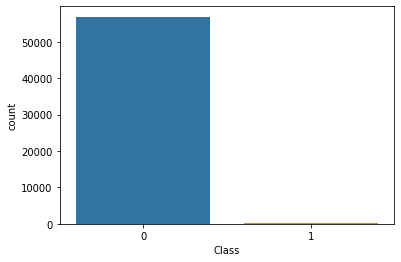

In [8]:
sns.countplot(df.Class)

In [9]:
## Get the Fraud and the normal dataset 

fraud = df[df['Class']==1]

normal = df[df['Class']==0]

In [11]:
outlier_fraction = len(fraud)/float(len(normal))
print(f'Number of Fraud cases :{fraud.shape[0]}')
print(f'Number of Normal cases :{normal.shape[0]}')
print(f'Outliars {outlier_fraction}')

Number of Fraud cases :96
Number of Normal cases :56865
Outliars 0.0016882089158533368


In [12]:
# Amount of money used in  transaction
pd.concat([fraud.Amount.describe(), normal.Amount.describe()], axis=1)

,Amount,Amount
count,96.000000,56865.000000
mean,132.118125,88.649336
std,290.868205,261.383920
min,0.000000,0.000000
25%,1.000000,5.640000
50%,7.760000,21.940000
75%,104.007500,77.190000
max,1809.680000,19656.530000


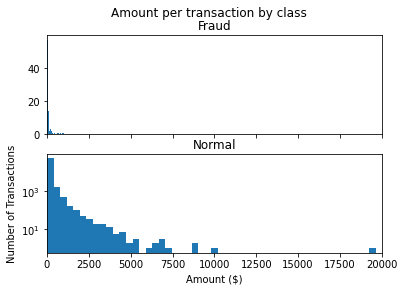

In [13]:
# Distribution of amaount of money
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

The mean fraud transactions is around 97\$ and goes to the max of 2125\$ whereas there is high distribution for normal transactions till 5000\$ and after 7500\$ there are odd transcations.

In [14]:
# Data in context of time
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False,)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

Fraudulent transactions have a distribution more even than valid transactions - are equaly distributed in time, including the low real transaction times, during night

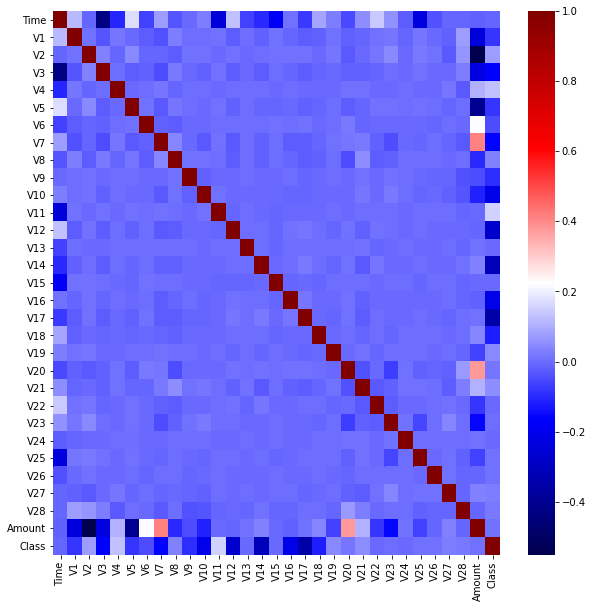

In [15]:
#get correlations of each features in dataset
plt.figure(figsize=(10,10))
sns.heatmap(data=df.corr(), cmap="seismic")
plt.show();

There is no notable correlation between features V1-V28. There are certain correlations between some of these features and Time (inverse corelation v3, v22) and Amount (direct correlation with V7 and V20, inverse correlation with V2 and V5).



---



**I will use different Algorithm to see which model perform best**

### Data Preperation

In [16]:
#Dependent variable
X = df[df.columns.drop('Class')]
# Target 
y = df['Class']

In [18]:
scalar = StandardScaler()
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y, 
                                                    test_size=0.3, random_state=42, stratify = y)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_v, y_train_v, 
                                                              test_size=0.2, random_state=42,stratify = y_train_v)

X_train = scalar.fit_transform(X_train)
X_validate = scalar.transform(X_validate)
X_test = scalar.transform(X_test)

In [20]:
#Distribution of transaction in Training set
y_train.value_counts()

0    31843
1       54
Name: Class, dtype: int64

In [21]:
#Distribution of transaction in Test set
y_test.value_counts()

0    17060
1       29
Name: Class, dtype: int64

In [22]:
#Distribution of transaction in validation set
y_train_v.value_counts()

0    39805
1       67
Name: Class, dtype: int64

In [23]:
w_p = y_train.value_counts()[0] / len(y_train)
w_n = y_train.value_counts()[1] / len(y_train)

print(f"Fraudulant transaction weight: {w_n}")
print(f"Non-Fraudulant transaction weight: {w_p}")

Fraudulant transaction weight: 0.0016929491801736841
Non-Fraudulant transaction weight: 0.9983070508198263


### Performance matrics


In [24]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

def print_score(label, prediction, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, prediction)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(label, prediction, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(label, prediction) * 100:.2f}%")
        print("_______________________________________________")
        print(f"Classification Report:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(label, prediction)}\n") 

## Models

### Isolation Forest Algorithm 

In [25]:
model = IsolationForest(n_estimators=100, max_samples=len(X_train), 
                        contamination='auto',random_state=90, verbose=0)
model.fit(X_train)
scores_prediction = model.decision_function(X_train)

In [33]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Because the predicted values are -1,1. We need to convert the values to calculate the performance matrices
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [35]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 99.60%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999213   0.219697  0.995987      0.609455      0.997893
recall         0.996765   0.537037  0.995987      0.766901      0.995987
f1-score       0.997988   0.311828  0.995987      0.654908      0.996826
support    31843.000000  54.000000  0.995987  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[31740   103]
 [   25    29]]

Test Result:
Accuracy Score: 99.56%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999177   0.197368  0.995611      0.598273      0.997816
recall         0.996424   0.517241  0.995611      0.756833      0.995611
f1-score       0.997799   0.285714  0.995611      0.641757      0.996590
support    17060.000000  29.

The confusion_matrix() function gives you just the correctly/misclassified point but does not the provide the information about how far the model is confident when it misclassifies a datapoint.

This information is used to create an ROC curve (which is used to measure ability of a model to rank each datapoint based on its likelihood towards a particular class).

Instead, use the decision_function() or score_samples() functions to calculate the model's confidence that each data point is (or is not) an anomaly. Then, use roc_curve() to get the points necessary to plot the curve itself.

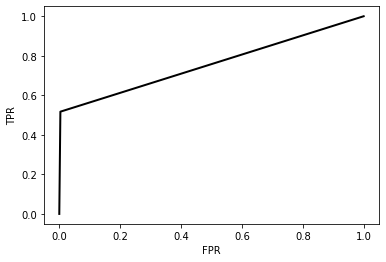

In [38]:
# Roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

---

We can adjust he threshhold and increase the recall depending upon the requirement.

In [85]:
model = IsolationForest(n_estimators=100, max_samples=len(X_train), 
                        contamination=.02,random_state=90, verbose=0)
model.fit(X_train)
scores_prediction = model.decision_function(X_train)

In [86]:
# After changing the contamination argument
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Because the predicted values are -1,1. We need to convert the values to calculate the performance matrices
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [87]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 98.11%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999712   0.070533  0.981127      0.535122      0.998139
recall         0.981377   0.833333  0.981127      0.907355      0.981127
f1-score       0.990460   0.130058  0.981127      0.560259      0.989003
support    31843.000000  54.000000  0.981127  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[31250   593]
 [    9    45]]

Test Result:
Accuracy Score: 98.24%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999702   0.075235  0.982445      0.537468      0.998133
recall         0.982708   0.827586  0.982445      0.905147      0.982445
f1-score       0.991132   0.137931  0.982445      0.564532      0.989684
support    17060.000000  29.

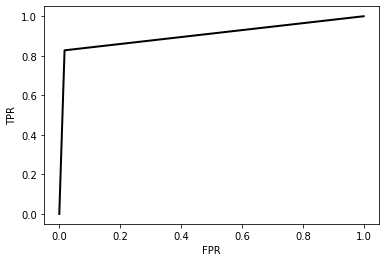

In [88]:
# Roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Result 
First model was : Accuracy Score: 99.56%

Recall for farud transactions :  **0.517241**


---


Second model was :Accuracy Score: 98.24%

Recall for farud transactions :  **0.82**
F1 Score = 0.220994

The second model perfoms better for identifying the fraud detetcions on the sacrifice of few errors in normal transactions. 

In [90]:
scores_dict = {
    'Isolation Forest': {
        'Train': f1_score(y_train, y_train_pred.round()),
        'Test': f1_score(y_test, y_test_pred.round()),
    },
}

### Local Outlier Factor

In [91]:
# with default parameters
model = LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                   leaf_size=30, metric='minkowski',
                    p=2, metric_params=None, contamination='auto')

In [92]:
y_train_pred = model.fit_predict(X_train)
y_test_pred = model.fit_predict(X_test)
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

In [93]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

Train Result:
Accuracy Score: 94.01%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.998468   0.004274   0.94012      0.501371      0.996785
recall         0.941463   0.148148   0.94012      0.544805      0.940120
f1-score       0.969128   0.008307   0.94012      0.488718      0.967501
support    31843.000000  54.000000   0.94012  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[29979  1864]
 [   46     8]]

Test Result:
Accuracy Score: 94.05%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999626   0.022265  0.940547      0.510946      0.997968
recall         0.940797   0.793103  0.940547      0.866950      0.940547
f1-score       0.969320   0.043315  0.940547      0.506317      0.967749
support    17060.000000  29.

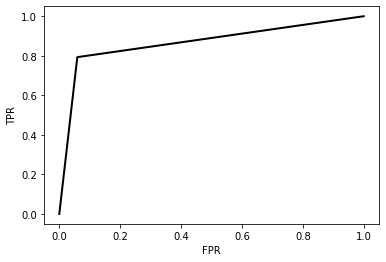

In [82]:
# Roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

In [94]:


scores_dict['Local Outlier Factor'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

In [95]:
scores_dict

{'Isolation Forest': {'Test': 0.13793103448275862,
  'Train': 0.13005780346820808},
 'Local Outlier Factor': {'Test': 0.04331450094161959,
  'Train': 0.008307372793354102}}

#### Result 

Accuracy Score: 94.05%

Recall for farud transactions :  **0.793103**

F1 Score = 0.043315


### SVM

In [96]:
model = OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)

In [97]:
model.fit(X_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
# Because the predicted values are -1,1. We need to convert the values to calculate the performance matrices
y_train_pred[y_train_pred == 1] = 0
y_train_pred[y_train_pred == -1] = 1
y_test_pred[y_test_pred == 1] = 0
y_test_pred[y_test_pred == -1] = 1

Train Result:
Accuracy Score: 93.88%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999632   0.021673  0.938803      0.510653      0.997977
recall         0.939045   0.796296  0.938803      0.867670      0.938803
f1-score       0.968392   0.042198  0.938803      0.505295      0.966824
support    31843.000000  54.000000  0.938803  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[29902  1941]
 [   11    43]]

Test Result:
Accuracy Score: 89.30%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999803   0.014046  0.893031      0.506925      0.998130
recall         0.893025   0.896552  0.893031      0.894788      0.893031
f1-score       0.943402   0.027660  0.893031      0.485531      0.941848
support    17060.000000  29.

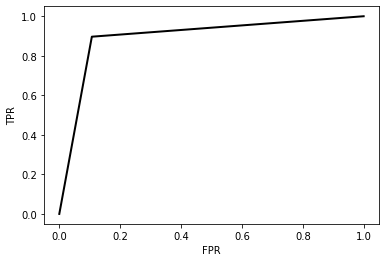

In [98]:
print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)
# Roc curve 
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Result 

Accuracy Score: 89.30%

Recall for farud transactions :  **0.896552**

F1 Score = 0.027660

In [99]:
scores_dict['SVM'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

### Ensemble learning : Boosting (XGBoost)

Train Result:
Accuracy Score: 99.98%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999843   1.000000  0.999843      0.999922      0.999843
recall         1.000000   0.907407  0.999843      0.953704      0.999843
f1-score       0.999921   0.951456  0.999843      0.975689      0.999839
support    31843.000000  54.000000  0.999843  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[31843     0]
 [    5    49]]

Test Result:
Accuracy Score: 99.95%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999531   1.000000  0.999532      0.999766      0.999532
recall         1.000000   0.724138  0.999532      0.862069      0.999532
f1-score       0.999766   0.840000  0.999532      0.919883      0.999494
support    17060.000000  29.

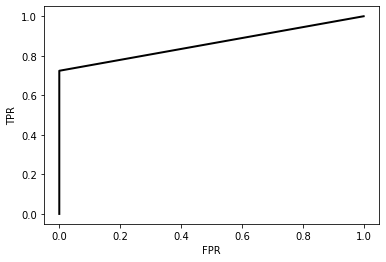

In [100]:
model = XGBClassifier()
model.fit(X_train, y_train, eval_metric='aucpr')

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Result 

Accuracy Score: 99.95%

Recall for farud transactions : **0.724138**

F1 Score = 0.840000

In [101]:
scores_dict['XGBoost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

### Ensemble learning : Bagging (Random Forest)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                 0     1  accuracy  macro avg  weighted avg
precision      1.0   1.0       1.0        1.0           1.0
recall         1.0   1.0       1.0        1.0           1.0
f1-score       1.0   1.0       1.0        1.0           1.0
support    31843.0  54.0       1.0    31897.0       31897.0
_______________________________________________
Confusion Matrix: 
 [[31843     0]
 [    0    54]]

Test Result:
Accuracy Score: 99.94%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999473   0.909091  0.999356      0.954282      0.999319
recall         0.999883   0.689655  0.999356      0.844769      0.999356
f1-score       0.999678   0.784314  0.999356      0.891996      0.999312
support    17060.000000  29.000000  0.999356  17089.000000  17089.000000
___________________

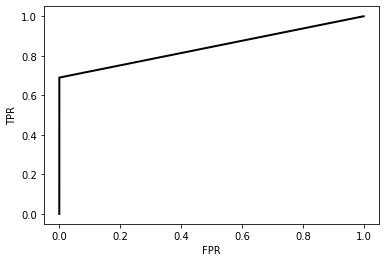

In [102]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, oob_score=False)
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Result 

Accuracy Score: 99.95%

Recall for farud transactions : **0.724138**

F1 Score = 0.840000

In [103]:
scores_dict['Random Forest'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

### CatBoost

In [104]:
! pip install catboost

Learning rate set to 0.045189
0:	learn: 0.5455052	total: 27.2ms	remaining: 27.1s
1:	learn: 0.4328810	total: 55.8ms	remaining: 27.9s
2:	learn: 0.3430939	total: 79.5ms	remaining: 26.4s
3:	learn: 0.2765789	total: 104ms	remaining: 26s
4:	learn: 0.2188550	total: 127ms	remaining: 25.3s
5:	learn: 0.1686313	total: 149ms	remaining: 24.8s
6:	learn: 0.1373156	total: 174ms	remaining: 24.6s
7:	learn: 0.1071481	total: 199ms	remaining: 24.7s
8:	learn: 0.0838302	total: 224ms	remaining: 24.7s
9:	learn: 0.0658656	total: 251ms	remaining: 24.9s
10:	learn: 0.0524981	total: 275ms	remaining: 24.7s
11:	learn: 0.0417985	total: 296ms	remaining: 24.4s
12:	learn: 0.0339615	total: 329ms	remaining: 25s
13:	learn: 0.0278846	total: 360ms	remaining: 25.3s
14:	learn: 0.0229796	total: 382ms	remaining: 25.1s
15:	learn: 0.0188266	total: 408ms	remaining: 25.1s
16:	learn: 0.0157251	total: 432ms	remaining: 25s
17:	learn: 0.0134043	total: 454ms	remaining: 24.8s
18:	learn: 0.0113066	total: 476ms	remaining: 24.6s
19:	learn: 0.0

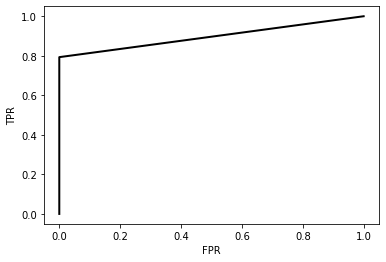

In [105]:
model = CatBoostClassifier()
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Result 

Accuracy Score: 99.96%

Recall for farud transactions : **0.793103**

F1 Score = 0.884615

In [106]:
scores_dict['Catboost'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

### LigthGBM

Train Result:
Accuracy Score: 99.76%
_______________________________________________
Classification Report:
                      0     1  accuracy     macro avg  weighted avg
precision      0.998306   0.0  0.997617      0.499153      0.996616
recall         0.999309   0.0  0.997617      0.499655      0.997617
f1-score       0.998807   0.0  0.997617      0.499404      0.997116
support    31843.000000  54.0  0.997617  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[31821    22]
 [   54     0]]

Test Result:
Accuracy Score: 99.65%
_______________________________________________
Classification Report:
                      0     1  accuracy     macro avg  weighted avg
precision      0.998300   0.0  0.996489      0.499150      0.996606
recall         0.998183   0.0  0.996489      0.499091      0.996489
f1-score       0.998241   0.0  0.996489      0.499121      0.996547
support    17060.000000  29.0  0.996489  17089.000000  17089.000000
_____

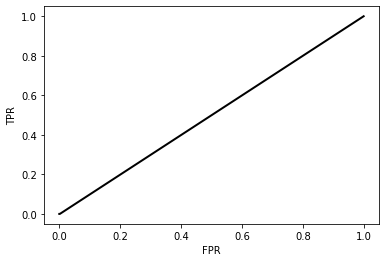

In [107]:
from lightgbm import LGBMClassifier

model = LGBMClassifier()
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred, train=True)
print_score(y_test, y_test_pred, train=False)

fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
plt.plot(fpr, tpr, 'k-', lw=2)
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Result 

Accuracy Score: 99.65%

Recall for farud transactions : **0**

F1 Score = 0

In [108]:
scores_dict['LigthGBM'] = {
        'Train': f1_score(y_train,y_train_pred),
        'Test': f1_score(y_test, y_test_pred),
}

### Multilayer Neural Network with Tensorflow/Keras

In [63]:
from tensorflow import keras

model = keras.Sequential([
    keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[-1],)),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation='sigmoid'),
])

In [65]:
METRICS = [
#     keras.metrics.Accuracy(name='accuracy'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

model.compile(optimizer=keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=METRICS)

callbacks = [keras.callbacks.ModelCheckpoint('fraud_model_at_epoch_{epoch}.h5')]

r = model.fit(
    X_train, y_train, 
    validation_data=(X_validate, y_validate),
    batch_size=2048, 
    epochs=300, 
    callbacks=callbacks, )


Epoch 1/300
16/16 [==============================] - 5s 148ms/step - loss: 0.8152 - fn: 4.4706 - fp: 8117.9412 - tn: 10062.1765 - tp: 24.4706 - precision: 0.0028 - recall: 0.8137 - val_loss: 0.5847 - val_fn: 2.0000 - val_fp: 185.0000 - val_tn: 7777.0000 - val_tp: 11.0000 - val_precision: 0.0561 - val_recall: 0.8462
Epoch 2/300
16/16 [==============================] - 1s 83ms/step - loss: 0.6079 - fn: 1.9412 - fp: 5178.2353 - tn: 13003.3529 - tp: 25.5294 - precision: 0.0045 - recall: 0.9460 - val_loss: 0.4708 - val_fn: 2.0000 - val_fp: 99.0000 - val_tn: 7863.0000 - val_tp: 11.0000 - val_precision: 0.1000 - val_recall: 0.8462
Epoch 3/300
16/16 [==============================] - 1s 83ms/step - loss: 0.4824 - fn: 3.3529 - fp: 2486.8824 - tn: 15689.4706 - tp: 29.3529 - precision: 0.0115 - recall: 0.9153 - val_loss: 0.3328 - val_fn: 2.0000 - val_fp: 14.0000 - val_tn: 7948.0000 - val_tp: 11.0000 - val_precision: 0.4400 - val_recall: 0.8462
Epoch 4/300
16/16 [==============================] - 

In [66]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print_score(y_train, y_train_pred.round(), train=True)
print_score(y_test, y_test_pred.round(), train=False)

Train Result:
Accuracy Score: 100.00%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999969   1.000000  0.999969      0.999984      0.999969
recall         1.000000   0.981481  0.999969      0.990741      0.999969
f1-score       0.999984   0.990654  0.999969      0.995319      0.999969
support    31843.000000  54.000000  0.999969  31897.000000  31897.000000
_______________________________________________
Confusion Matrix: 
 [[31843     0]
 [    1    53]]

Test Result:
Accuracy Score: 99.94%
_______________________________________________
Classification Report:
                      0          1  accuracy     macro avg  weighted avg
precision      0.999356   1.000000  0.999356      0.999678      0.999357
recall         1.000000   0.620690  0.999356      0.810345      0.999356
f1-score       0.999678   0.765957  0.999356      0.882818      0.999281
support    17060.000000  29

#### Result 

Accuracy Score: 99.94%

Recall for farud transactions : **0.620690**

F1 Score = 0.765957

In [110]:
scores_dict['ANN'] = {
        'Train': 0.990654,
        'Test': 0.765957,
}

In [111]:
scores_dict

{'ANN': {'Test': 0.765957, 'Train': 0.990654},
 'Catboost': {'Test': 0.8846153846153846, 'Train': 1.0},
 'Isolation Forest': {'Test': 0.13793103448275862,
  'Train': 0.13005780346820808},
 'LigthGBM': {'Test': 0.0, 'Train': 0.0},
 'Local Outlier Factor': {'Test': 0.04331450094161959,
  'Train': 0.008307372793354102},
 'Random Forest': {'Test': 0.7843137254901961, 'Train': 1.0},
 'SVM': {'Test': 0.027659574468085108, 'Train': 0.042198233562315994},
 'XGBoost': {'Test': 0.8400000000000001, 'Train': 0.9514563106796117}}

### Observations :

**Type I error and Type II error**

To clarify that confussion matrix are not a very good tool to represent the results in the case of largely unbalanced data, because we will actually need a different metrics that accounts in the same time for the selectivity and specificity of the method we are using, so that we minimize in the same time both Type I errors and Type II errors.

**Null Hypothesis** (H0) - The transaction is not a fraud.
Alternative Hypothesis (H1) - The transaction is a fraud.

**Type I error** - You reject the null hypothesis when the null hypothesis is actually true.

**Type II error** - You fail to reject the null hypothesis when the the alternative hypothesis is true.

**Cost of Type I error**   - You erroneously presume that the the transaction is a fraud, and a true transaction is rejected.

**Cost of Type II error** - You erroneously presume that the transaction is not a fraud and a fraudulent transaction is accepted.



In this usecase, we need to reduce False negative so that we can catch more fraudlent cases.

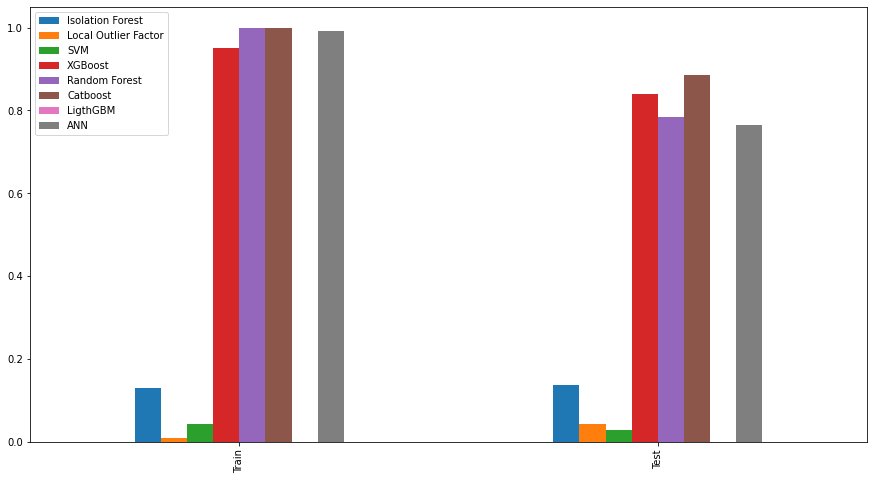

In [113]:
scores_df = pd.DataFrame(scores_dict)

scores_df.plot(kind='bar', figsize=(15, 8))

After comparing 8 different models, we can see that **CATBoost** performed best.

Accuracy : 99.9%

F1-score : 0.884615